In [115]:
import itertools
import csv

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from torchquad import (
    set_up_backend,
    Trapezoid,
    Simpson,
    MonteCarlo,
    Gaussian,
    GaussLegendre,
)
import torch
from torch import exp, sin, cos

In [117]:
set_up_backend("torch", data_type="float32")
tp = Gaussian()

## Konstante i osnovne funkcije

In [21]:
kb = 8.6173303 * 10 ** (-5)
hbar = 6.582119569 * 10 ** (-16)
pi = np.pi

alpha_op = 0.4
alpha_ac = 1
hbar_w_op = torch.Tensor([0.4]).to("cuda")
eta_0 = 1 * 10 ** (-3)
M = 0.0
Kf_20 = 0.2  # eV, Fermi at 20K
vf = 4 * 10**5
a = 100 ** (1 / 3) * 10 ** (-10)
T_0 = 4
T_F = Kf_20 / kb

Kf_ = Kf_20 / hbar / vf * a  # Fermi unitless
Kf_max = 1 / hbar / vf * a  # cutoff 1eV unitless
c_s_tilde = 0.03  # hbar_w_ac_max / hbar / vf * a
hbar_w_ac_max = c_s_tilde * hbar * vf / a
G_op2 = alpha_op
G_ac2 = alpha_ac * hbar * vf / a
K_c = Kf_max

Ef = torch.sqrt(torch.FloatTensor([Kf_20**2 + M**2])).to("cuda")

In [4]:
def arrays_to_csv(array1, array2, name):
    with open(f"{name}.csv", "w", newline="") as file:
        writer = csv.writer(file)
        for a1, a2 in zip(array1, array2):
            writer.writerow([round(a1, 5), a2])

In [11]:
def fermi_dirac(E, Ef, T):
    if T > 0:
        return torch.where(
            E > Ef,
            exp((-E + Ef) / (kb * T)) / (exp((-E + Ef) / (kb * T)) + 1),
            1 / (exp((E - Ef) / (kb * T)) + 1),
        )
    else:
        return torch.where(E > Ef, 0, 1)


def d_fermi_dirac(E, Ef, T):
    return 1 / kb / T * fermi_dirac(E, Ef, T) * (1 - fermi_dirac(E, Ef, T))


def bose_einstein(E, T):
    if T == 0:
        return 0
    return torch.where(E > 0, exp(-E / (kb * T)) / (-exp(-E / (kb * T)) + 1), 0)


def chemical_potential(T):
    return (
        Ef
        - pi**2 / 6 * (2 * Ef**2 - M**2) / Ef / (Ef**2 - M**2) * (kb * T) ** 2
        - 7 / 360 * pi**4 * 3 * M**4 / Ef / (Ef**2 - M**2) ** 3 * (kb * T) ** 4
    )


def eps(K):
    arg = hbar**2 * vf**2 / a**2 * K**2 + M**2
    if isinstance(K, torch.Tensor):
        return torch.sqrt(arg)
    else:
        return np.sqrt(arg)


def eff_concetration(T):
    def integrand(k):
        return 2 / hbar / vf / a**2 * fermi_dirac(eps(k), Ef, T) * k

    return (
        4
        * pi
        / 3
        * 2
        / (2 * pi) ** 3
        * vf**2
        * integrate.quad(integrand, 0, Kf_max, limit=80000)[0]
    )


def coupling(K_c, abs_dK):
    return G_op2 * torch.where(K_c > abs_dK, 1, 0)

In [6]:
print(eff_concetration(0))  # T=0 numerički
print(4 * pi / 3 * 2 / (2 * pi) ** 3 * Kf_20**2 / hbar**3 / vf)  # T=0 analitički

1.1843544863015165e+37
1.184354454914293e+37


In [39]:
ws_0 = torch.arange(0, 1, 0.01)
from tqdm import tqdm_notebook


def calculate_integral_points(
    mem_fn, real_sum, imag_sum, hbar_w_ph, T=T_0, eta=eta_0, ws=ws_0, u=Kf_20, K_c=K_c
):

    result_real = []

    result_imag = []

    for w in tqdm_notebook(ws):

        result_real.append(
            mem_fn(real_sum, w, hbar_w_ph, u, T=T, eta=eta, K_c=K_c).to("cpu")
        )

        result_imag.append(
            mem_fn(imag_sum, w, hbar_w_ph, u, T=T, eta=eta, K_c=K_c).to("cpu")
        )

    return result_real, result_imag


def setup_plot(real=True, imag=True, x_lim=[0.0, 0.05], y_lim=[0, 0.06]):

    fig, ax1 = plt.subplots()

    ax1.set_xlabel(r"$\hbar \omega [eV]$")

    if real:

        ax1.set_ylabel(r"$\hbar Re\{M_x\} [eV]$")

    else:

        ax1.set_ylabel(r"$\hbar Im\{M_x\} [eV]$")

    ax1.set_xlim(x_lim)

    ax1.set_ylim(y_lim)

    ax2 = ax1.twinx()

    if imag and real:

        ax2.set_ylabel(r"$\hbar Im\{M_x\} [eV]$")

    ax2.set_xlim(x_lim)

    ax2.set_ylim(y_lim)

    return fig, ax1, ax2


def plot_real_and_imag_result(
    ax1, ax2, result_real, result_imag, T=None, eta=None, ws=ws_0
):
    assert T or eta

    ax1.plot(
        ws.to("cpu"), result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV"
    )

    ax2.plot(ws.to("cpu"), result_imag)

    if T:

        plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)

    else:

        plt.text(0.020, 0.002, f"T={T_0} K", fontsize=10)


def plot_result(ax, result, T=None, eta=None, ws=ws_0):

    ax.plot(ws.to("cpu"), result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")

<>:63: SyntaxWarning: invalid escape sequence '\e'
<>:70: SyntaxWarning: invalid escape sequence '\e'
<>:79: SyntaxWarning: invalid escape sequence '\e'
<>:63: SyntaxWarning: invalid escape sequence '\e'
<>:70: SyntaxWarning: invalid escape sequence '\e'
<>:79: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Patrik\AppData\Local\Temp\ipykernel_508\1564089390.py:63: SyntaxWarning: invalid escape sequence '\e'
  ws.to("cpu"), result_real, label=f"T={T} K" if T else f"$\eta = $ {eta:.4f} eV"
C:\Users\Patrik\AppData\Local\Temp\ipykernel_508\1564089390.py:70: SyntaxWarning: invalid escape sequence '\e'
  plt.text(0.020, 0.002, f"$\eta = $ {eta_0:.4f} $eV$", fontsize=10)
C:\Users\Patrik\AppData\Local\Temp\ipykernel_508\1564089390.py:79: SyntaxWarning: invalid escape sequence '\e'
  ax.plot(ws.to("cpu"), result, label=f"T={T} K" if T else f"$\eta = $ {eta:.5f} eV")


## Optički fononi


**Memorijska funkcija**

In [110]:
def ss_sum_part(K_, phi_, K, phi, hbar_w, hbar_w_ph, T, u, eta, K_c):
    # abs_k_k_ = torch.sqrt(
    #     K**2
    #     + K_**2
    #     - 2
    #     * K
    #     * K_
    #     * (sin(theta) * sin(theta_) * cos(phi - phi_) + cos(theta) * cos(theta_))
    # )

    def summand(s1, s2):

        return (
            bose_einstein(hbar_w_ph, T) + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)

        ) / (hbar_w + s1 * eps(K_) - s1 * eps(K) + s2 * hbar_w_ph + eta * 1j)


    sum = 0

    for s1, s2 in itertools.product([-1, 1], [-1, 1]):

        sum = sum + summand(s1, s2)

    return (
        sum
        * K**2
        * K_**2
        # * sin(theta)
        # * sin(theta_)
        # * (cos(theta_) ** 2 - cos(theta) * cos(theta_))
        * d_fermi_dirac(eps(K_), Ef, T)
    )



def ss_sum_real(K_, phi_, K, phi, hbar_w, hbar_w_ph, T, u, eta, K_c):

    return ss_sum_part(K_, phi_, K, phi, hbar_w, hbar_w_ph, T, u, eta, K_c).real



def ss_sum_imag(K_, phi_, K, phi, hbar_w, hbar_w_ph, T, u, eta, K_c):

    return ss_sum_part(K_, phi_, K, phi, hbar_w, hbar_w_ph, T, u, eta, K_c).imag



def mem_fn_op(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta, K_c):

    integration_domain = torch.Tensor(
        [[0, Kf_max], [0, pi / 10], [0, Kf_max], [0, pi / 10]]
    )


    def integrand(K):

        return ss_sum_fn(
            K[:, 0],
            K[:, 1],
            K[:, 2],
            K[:, 3],
            hbar_w,
            hbar_w_ph,
            T,
            u,
            eta,
            K_c,
        )


    integral_k_k_ = tp.integrate(

        integrand, dim=4, N=10**7, integration_domain=integration_domain
    )


    return G_op2 * (
        (1 / eff_concetration(T) / a**3 * 2 / (2 * pi) ** 3 * 4 * pi / 3 * vf**2)
        * (-1 / (2 * pi) ** 2 * 2)
        * integral_k_k_
    )  # one factor 2 for 4\pi

C:\Users\Patrik\AppData\Local\Temp\ipykernel_508\1564089390.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for w in tqdm_notebook(ws):


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\autoray\autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
C:\Users\Patrik\AppData\Local\Temp\ipykernel_508\2467687982.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.array(ws_0.to("cpu")),
C:\Users\Patrik\AppData\Local\Temp\ipykernel_508\2467687982.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array

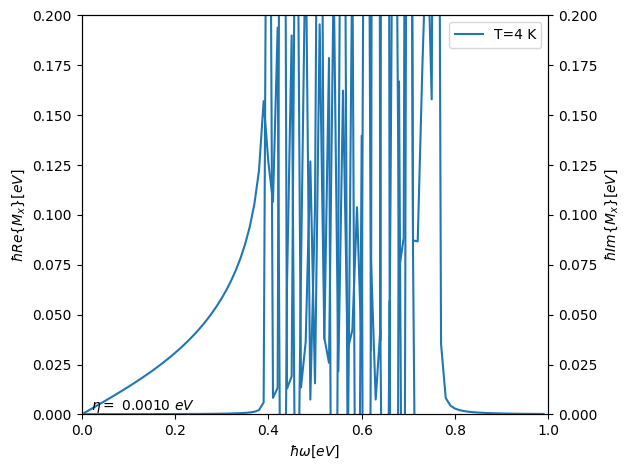

In [118]:
fig, *axs = setup_plot(x_lim=[0, 1], y_lim=[0, 0.2])
integrals = calculate_integral_points(
    mem_fn_op, ss_sum_real, ss_sum_imag, hbar_w_op, T=T_0
)
arrays_to_csv(
    np.array(ws_0.to("cpu")),
    np.array(integrals[0]),
    f"op, real, T={T_0}K, eta={eta_0}eV",
)
arrays_to_csv(
    np.array(ws_0.to("cpu")),
    list(np.array(integrals[1])),
    f"op, imag, T={T_0}K, eta={eta_0}eV",
)
plot_real_and_imag_result(*axs, *integrals, T=T_0)
axs[0].legend(loc="best")
fig.tight_layout()

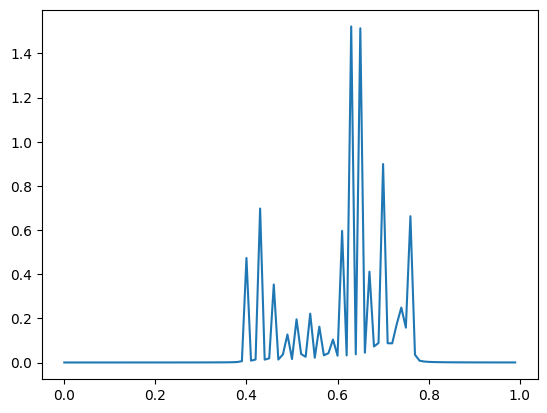

In [119]:
plt.plot(ws_0.to("cpu"), integrals[1])

## Akustični fononi

**Memorijska funkcija**

In [ ]:
def ss_sum_part_ac(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    def summand(s1, s2):
        abs_K = torch.sqrt(K**2 + Kf_**2 - 2 * Kf_ * K * sin(theta) * cos(phi))
        factor = 1 - K * sin(theta) * cos(phi) * Ef / eps(K) / Kf_
        return (
            (
                bose_einstein(hbar_w_ph * abs_K, T)
                + fermi_dirac(s1 * s2 * eps(K), s1 * s2 * u, T)
            )
            / (hbar_w + s1 * Ef - s1 * eps(K) + s2 * hbar_w_ph * abs_K + eta * 1j)
            * abs_K
            * factor
        )

    sum = 0
    for s1, s2 in itertools.product([-1, 1], [-1, 1]):
        sum = sum + summand(s1, s2)
    return sum * K**2 * sin(theta)


def ss_sum_real_ac(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part_ac(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta).real


def ss_sum_imag_ac(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta):
    return ss_sum_part_ac(K, theta, phi, hbar_w, hbar_w_ph, T, u, eta).imag


def mem_fn_ac(ss_sum_fn, hbar_w, hbar_w_ph, u, T, eta):

    integration_domain = torch.Tensor([[0, Kf_max], [0, pi], [0, 2 * pi]])
    tp = MonteCarlo()

    def integrand(K):
        return ss_sum_fn(K[:, 0], K[:, 1], K[:, 2], hbar_w, hbar_w_ph, T, u, eta)

    integral_k_theta_phi = tp.integrate(
        integrand, dim=3, N=10**6 * 3, integration_domain=integration_domain
    )

    return -G_ac2 * integral_k_theta_phi / (2 * pi) ** 3

c:\Users\Patrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


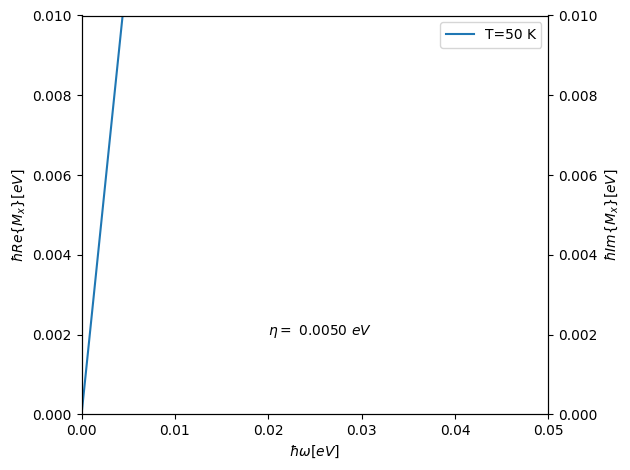

In [26]:
fig, *axs = setup_plot(y_lim=[0, 0.01])
integrals = calculate_integral_points(
    mem_fn_ac,
    ss_sum_real_ac,
    ss_sum_imag_ac,
    hbar_w_ac_max,
    T=T_0,
    ws=ws_0,
)
plot_real_and_imag_result(*axs, *integrals, T=T_0, ws=ws_0)
axs[0].legend(loc="best")
fig.tight_layout()

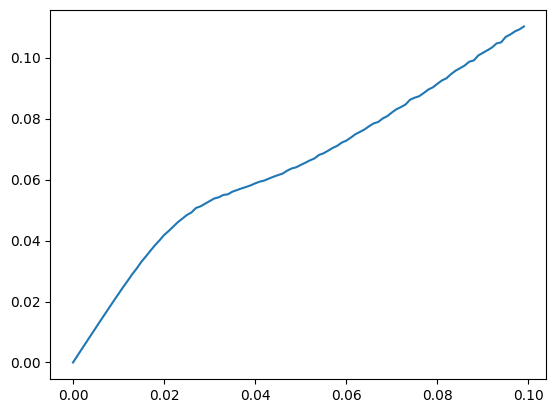

In [27]:
plt.plot(ws_0.to("cpu")[:100], integrals[0][:100])
# plt.plot(ws_0.to("cpu"), integrals[1])